## Info

This is a notebook for a take home project from Way2B1.

The specifications for the assigment are:

Way2B1: Machine Learning Take Home Exercise
Project: Start benefiting from having too much email (or analyze your email inbox). Goal is to
connect to your email, apply a ML technique and produce a useful insight. This is very open
ended, so reach out for clarification if that’s overwhelming. Expected time commitment: 4-6
hours, but if useful to your portfolio then longer. If short on time, then you can write up how
you plan to approach each step of the project.

**Details:**

    ● Open a gmail account if you don’t already have one that you can use ( you can use any
    email provider that has an API, if you don’t want to use gmail)
    ○ If a new account, then you’ll need to figure out how to get some email into via
    some subscriptions, or sending test messages. Maybe forward non-sensitive, yet
    substantive (non-spam) messages from your primary email account

    ● Connect to Gmail’s API (https://developers.google.com/gmail/api/quickstart/python)

    ● Model: Choose a model or framework that you think will be useful in producing an insight
    related to your emails

    ● Algorithm: Select an algorithm that can be used to produce an insight or prediction from
    your emails. Spam detection is the canonical email analysis use case, you’re welcome to
    do it, but we’d prefer to see something else, like needs a reply, has an important event,
    or classifying emails into meaningful categories. It’s up to you and creativity is great.

    ● Features (if applicable): Identify useful features from each email (example: sender,
    sender domain, has attachments, keywords of email message etc). You don’t need to
    identify every possible feature, just some interesting ones that will support your
    insights.

    ● Data (sets depend on approach): Select a certain set of emails as your training set, a
    certain set as a validation set (optional), and a certain set as a test set (or just any
    arbitrary new email). You can probably use gmail labels to achieve this, but use whatever
    method is easiest for you.
    
**Languages: Python or JS, also you’re welcome to use any ML platform or infrastructure that you’re comfortable with**

**Submission:**

    ● Share a Github or Gitlab repo containing the code from the take-home

    ● README summarizing your approach and findings

    ● You’re free to use this code for any other purpose that you see fit outside of the take home evaluation 

**Evaluation:**

    ● Quality of implementation of algorithm

    ● Understandable explanation in README

    ● Legible, well designed code

    ● We’ll discuss the takehome in subsequent interviews.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## google imports

from __future__ import print_function
import os.path

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp
import time
import os


from bs4 import BeautifulSoup
import base64
import email

In [3]:
import MyGmailAPI

In [4]:
SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']
creds = Credentials.from_authorized_user_file('token.json', SCOPES)
service = build('gmail', 'v1', credentials=creds)

# ## QUICK TEST
# labels_filter = ['SENT','INBOX','IMPORTANT','TRASH','SPAM','CATEGORY_FORUMS',
#                  'CATEGORY_UPDATES','CATEGORY_PERSONAL','CATEGORY_PROMOTIONS',
#                  'CATEGORY_SOCIAL','STARRED','UNREAD']

## apperently you have to add 'or'
# labels_filter = ['CATEGORY_PROMOTIONS'or'CATEGORY_UPDATES'or'CATEGORY_SOCIAL'or'SPAM']

# results = service.users().messages().list(maxResults=100, includeSpamTrash=True,
#                                           labelIds=labels_filter,
#                                           userId="me").execute()
# msg = results.get('messages')
# txt = service.users().messages().get(userId='me', id=msg[0]['id'],
#                                              format="full", metadataHeaders=None).execute()
# txt

In [5]:
# ## confirmation test no chats
# for m in msg:
#     txt = service.users().messages().get(userId='me', id=m['id'],
#                                                  format="full", metadataHeaders=None).execute()    
#     if 'CHAT' in str(txt['labelIds']):
#         print('chat')

In [6]:
# help(service.users().messages().list)

### Call the MyGMAIL API Class

In [7]:
gapi = MyGmailAPI.GmailAPI(SCOPES, creds, service)

In [8]:
res = gapi.get_results(iters=1)

Chat count = 0
time to complete = 0.893 mins


In [12]:
gapi.all_messages_cleaned[0].head()

,subject,sender,snippet,labels
0,World Baseball Classic announce official broad...,"""MLB.com Insider"" <info@mail.mlblists.com>","MLB October 27, 2022 View Online The road to t...","[UNREAD, CATEGORY_UPDATES, INBOX]"
1,"Find community, path and purpose",Patagonia <reply@email.patagonia.com>,Patagonia Action Works makes it easy to make a...,"[CATEGORY_PROMOTIONS, UNREAD, INBOX]"
2,5 reasons to give $5 just 5 days out from our ...,Tammy Duckworth for Senate <tammy@e.tammyduckw...,Help Tammy hit her LAST monthly goal before El...,"[CATEGORY_PROMOTIONS, UNREAD, INBOX]"
3,"Re: B, if you can find 15 minutes to spare bef...",Daily Kos <campaigns@dailykos.com>,"B, after failing to overturn the 2020 presiden...","[UNREAD, IMPORTANT, CATEGORY_UPDATES, INBOX]"
4,Enter for a chance to score Nita Strauss' favo...,Guitar Center <guitarcenter@notes.guitarcenter...,"Hi, win a BOSS GT-1000 effects pedal, plus mor...","[CATEGORY_PROMOTIONS, UNREAD, INBOX]"


### FUNCTIONS

- Had some trouble when SCOPES, creds, and service were not global and because of this, my functions were unable to be built into a class.
- Google API is painful to work with
- Google API references used:
    - https://stackoverflow.com/questions/43269704/gmail-api-getting-all-gmail-inbox-messages-limits-to-500
    - https://stackoverflow.com/questions/55144261/python-how-to-get-the-subject-of-an-email-from-gmail-api
    - https://stackoverflow.com/questions/43269704/gmail-api-getting-all-gmail-inbox-messages-limits-to-500
    - https://www.geeksforgeeks.org/how-to-read-emails-from-gmail-using-gmail-api-in-python/
    - https://stackoverflow.com/questions/41761245/gmail-api-pagination-use-of-nextpagetoken
    - https://medium.com/nat-personal-relationship-manager/full-gmail-api-guide-how-to-retrieve-email-metadata-to-use-it-in-your-app-511c77017326

In [13]:
allm = []

labels = ['CATEGORY_PROMOTIONS','CATEGORY_UPDATES','CATEGORY_SOCIAL','SPAM']

for lab in labels:
    print(f"Pulling emails for label: {lab}")
    tmp = gapi.get_results(iters=5, label_filter=lab)
#     tmp = get_results(iters=5, label_filter=lab)
    allm.append(gapi.all_messages_cleaned)


Pulling emails for label: CATEGORY_PROMOTIONS
Chat count = 0
time to complete = 0.805 mins
Chat count = 0
time to complete = 0.805 mins
Chat count = 0
time to complete = 0.768 mins
Chat count = 0
time to complete = 0.786 mins
Chat count = 0
time to complete = 0.802 mins
Pulling emails for label: CATEGORY_UPDATES
Chat count = 0
time to complete = 0.773 mins
Chat count = 0
time to complete = 0.841 mins
Chat count = 0
time to complete = 0.888 mins
Chat count = 0
time to complete = 0.898 mins
Chat count = 0
time to complete = 0.806 mins
Pulling emails for label: CATEGORY_SOCIAL
Chat count = 0
time to complete = 0.589 mins
Chat count = 0
time to complete = 0.545 mins
Chat count = 0
time to complete = 0.550 mins
Chat count = 0
time to complete = 0.552 mins
Chat count = 0
time to complete = 0.526 mins
Pulling emails for label: SPAM
Chat count = 0
time to complete = 0.814 mins
Chat count = 0
time to complete = 0.040 mins
Chat count = 0
time to complete = 0.729 mins
Chat count = 0
time to compl

In [14]:
print(len(allm))
allm_df = pd.concat([i[0] for i in allm], axis=0)
print(allm_df.shape)

4
(1870, 4)


In [15]:
allm_df.head(10)

,subject,sender,snippet,labels
0,"Find community, path and purpose",Patagonia <reply@email.patagonia.com>,Patagonia Action Works makes it easy to make a...,"[CATEGORY_PROMOTIONS, UNREAD, INBOX]"
1,5 reasons to give $5 just 5 days out from our ...,Tammy Duckworth for Senate <tammy@e.tammyduckw...,Help Tammy hit her LAST monthly goal before El...,"[CATEGORY_PROMOTIONS, UNREAD, INBOX]"
2,Enter for a chance to score Nita Strauss' favo...,Guitar Center <guitarcenter@notes.guitarcenter...,"Hi, win a BOSS GT-1000 effects pedal, plus mor...","[CATEGORY_PROMOTIONS, UNREAD, INBOX]"
3,Make some noise: Holiday deals are here,Guitar Center <guitarcenter@notes.guitarcenter...,"Hi, put down the pumpkin spice, pick up some s...","[CATEGORY_PROMOTIONS, UNREAD, INBOX]"
4,EXTRA 30% OFF CLEARANCE! Shop now for up to 80...,Duluth Trading <duluthtrading@email.duluthtrad...,PLUS - save 30% on everything in-store and onl...,"[CATEGORY_PROMOTIONS, UNREAD, INBOX]"
5,Do not sleep on state legislative races.,Pennsylvania Working Families Party <reply@wor...,"We have to vote Republicans out, one by one, d...","[CATEGORY_PROMOTIONS, UNREAD, INBOX]"
6,Fossil fuel lobbyists are packing their bags. ...,"""Omar Elmawi - 350.org"" <350@350.org>",10 days until the global climate talks begin. ...,"[CATEGORY_PROMOTIONS, UNREAD, INBOX]"
7,✅ 𝐘𝐄𝐒 or ❌ 𝐍𝐎: have you voted yet?,"""response missing || TEAM CADEM"" <info@cadem.org>",we need your immediate input! 📅 CALENDAR ALERT...,"[CATEGORY_PROMOTIONS, UNREAD, INBOX]"
8,partisan hacks like Ben Shapiro just don’t get...,Team McMullin <info@evanmcmullin.com>,‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ...,"[CATEGORY_PROMOTIONS, UNREAD, INBOX]"
9,TUESDAY: Join us for Remaking American Democra...,Free Speech For People <contact@freespeechforp...,"On November 8, democracy is on the ballot. ‌ ‌...","[CATEGORY_PROMOTIONS, UNREAD, INBOX]"


In [16]:
allm_df.labels.value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[CATEGORY_PROMOTIONS, UNREAD, SPAM]                                 424
[CATEGORY_PROMOTIONS, UNREAD, TRASH]                                288
[UNREAD, TRASH, CATEGORY_SOCIAL]                                    238
[UNREAD, TRASH, CATEGORY_UPDATES]                                   213
[CATEGORY_PROMOTIONS, UNREAD, INBOX]                                155
[IMPORTANT, TRASH, CATEGORY_UPDATES]                                139
[UNREAD, CATEGORY_PERSONAL, SPAM]                                    71
[UNREAD, IMPORTANT, TRASH, CATEGORY_UPDATES]                         62
[UNREAD, CATEGORY_UPDATES, SPAM]                                     42
[UNREAD, IMPORTANT, TRASH, CATEGORY_SOCIAL]                          33
[CATEGORY_SOCIAL, INBOX]                                             30
[UNREAD, IMPORTANT, CATEGORY_UPDATES, INBOX]                         27
[CATEGORY_PROMOTIONS, UNREAD, IMPORTANT, INBOX]                      23
[TRASH, CATEGORY_SOCIAL]                                        

In [17]:
allm_df.isnull().sum()

subject    0
sender     0
snippet    0
labels     0
dtype: int64

**Quick data type cleaning**

In [18]:
allm_df['labels'] = allm_df.labels.astype(str)
allm_df['subject'] = allm_df.subject.astype(str)
allm_df['sender'] = allm_df.sender.astype(str)
allm_df['snippet'] = allm_df.snippet.astype(str)

This data pull is by no means perfect, there are a lot of missing values and we could likely have worked out better ways in dealing with the errors. That in mind, we have a decent amount of instances from one of my email addresses that we can work through even with all of the "CHATS" that were pulled in.

In [20]:
allm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1870 entries, 0 to 499
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  1870 non-null   object
 1   sender   1870 non-null   object
 2   snippet  1870 non-null   object
 3   labels   1870 non-null   object
dtypes: object(4)
memory usage: 73.0+ KB


In [25]:
## saving down for later reference rather than waiting on the API call
##  for time constraints and larger data pyspark might be more appropriate
allm_df.to_parquet("data/pull_v6.parquet", engine='fastparquet', compression='BROTLI')

**Pull the data back in**

In [26]:
# df = pd.read_parquet("data/pull_v5.parquet")
df = pd.read_parquet("data/pull_v6.parquet")
print(df.shape)

df.head(3)

(1870, 4)


,subject,sender,snippet,labels
index,,,,
0,"Find community, path and purpose",Patagonia <reply@email.patagonia.com>,Patagonia Action Works makes it easy to make a...,"['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']"
1,5 reasons to give $5 just 5 days out from our ...,Tammy Duckworth for Senate <tammy@e.tammyduckw...,Help Tammy hit her LAST monthly goal before El...,"['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']"
2,Enter for a chance to score Nita Strauss' favo...,Guitar Center <guitarcenter@notes.guitarcenter...,"Hi, win a BOSS GT-1000 effects pedal, plus mor...","['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']"


In [27]:
print(f"Unique subjects = {df.subject.nunique()}")
print(f"Unique snippets = {df.snippet.nunique()}")
print(f"Unique senders = {df.sender.nunique()}")

Unique subjects = 1712
Unique snippets = 1623
Unique senders = 826


After a few iterations in working with the Google API we now have a stronger set of unique items. The snippets should be more unique I would think, however even after setting up the resets to avoid leaving variables in place in the function, there may still be some repetion happening.

**I had decided against working with the body of the emails in order to avoid any further time constraints.**

### WHAT DO I WANT TO KNOW?

- How many of these emails are political related? I get a ton of these asking for donations and signatures.
    - Is there anything specific to mark them as donation?
    - Maybe we can build a model out of this?
    
- Who are my most frequent senders?
    - Do I even know most of them?
    - If I clean this up will it significantly narrow down the list?
    
- How many of these are data science related?
    - Will we be able to confirm they are data science related from the subject or snippet? Alot of emails talk about data in general.
    - Is there any specific in these data science emails?

In [28]:
df.subject.value_counts()

Calvin and Hobbes shared "Calvin and Hobbes by Bill Watterson for Oc...    9
New comment in Model Deployment Made Easy                                  8
Your Bonus Thursday Lesson Inside                                          8
Re: [Iron City Roller Hockey] In for tomorrow                              7
Mobilization Update | Weekly Textbanks to Get Out the Vote                 6
                                                                          ..
GOTV volunteers needed: Get out the early vote                             1
ADA 75th All-Star: Paul Wellstone                                          1
Yaheetech Drafting Table                                                   1
Occupy Park Avenue                                                         1
YOU CAN BE THE DIFFERENCE: Become an SDCC Ambassador!                      1
Name: subject, Length: 1712, dtype: int64

**There are a lot of "emails" without subjects at all.**

In [29]:
df.snippet.value_counts()

‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌    134
‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌‌     10
Kimani Shaw sent you a message. Open Messenger You&#39;ll need to use Messenger to see and respond to Kimani &#39;s message. With Messenger, you can send messages, and make voice and video calls for         5
Thank you for contacting my office! If you are writing to me about your opinion on an issue or a piece of legislation, please read below: Too often, constituents remain silent on legislation and             4
Marissa Laskey sent you a message. Open Messenger You&#39;ll need to use Messenger to see and respond to Marissa &#39;s message. With Messenger, you can text, and m

In [30]:
df['labels'] = df.labels.astype(str)
df['subject'] = df.subject.astype(str)
df['sender'] = df.sender.astype(str)
df['snippet'] = df.snippet.astype(str)

In [31]:
import re
from sklearn.feature_extraction import _stop_words
from collections import Counter

In [134]:
def textClean(text):
    ''' Text Cleaning Function
        I used this in a kaggle comp a long time ago so its a little redundant and wonky.
        Most NLP modules have built ins for this now.
        
        Prams:
        = = = = = = = = = = = = = = = = = = = = 
        text = text string
        
        Return:
        = = = = = = = = = = = = = = = = = = = = 
        Cleaned text
    '''
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"[-()\"#/@;:<>{}=~|.?,]", "", text)
    text = text.lower().split()
    
    extra_stops = ['wildbillschill','nicole','lewis','google','gmail','nicolelewis','bill','schill',
                   'hnatkovich','re','th','com']
    
    stops = list(_stop_words.ENGLISH_STOP_WORDS) + extra_stops
    text = [w for w in text if not w in _stop_words.ENGLISH_STOP_WORDS]   
    
    text = " ".join(text)
    text = text.replace("."," ").replace(","," ").replace('-'," ").replace("',","")
    return(text)

Text(0.5, 1.0, 'Top Twenty Counts of Most-Common Words Among SUBJECT')

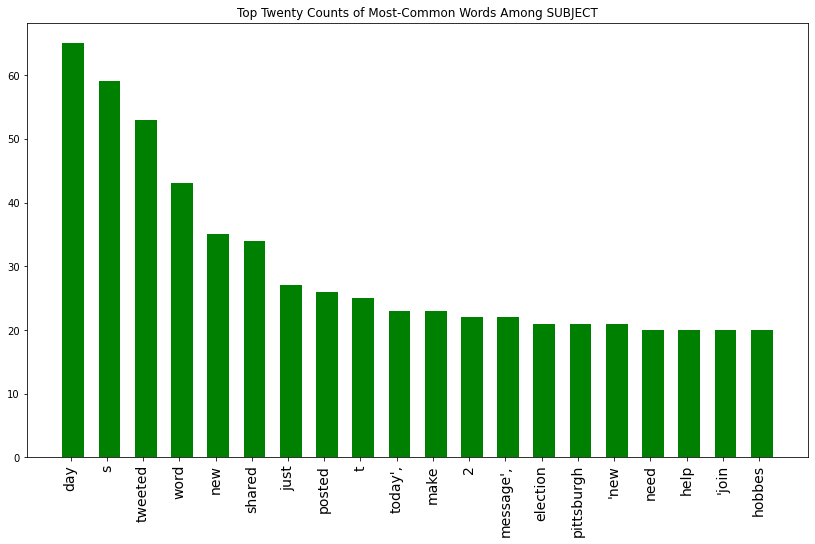

In [135]:
trainText = []
for it in df['subject']:
    newT = textClean(it)
    trainText.append(newT)

tops = Counter(str(trainText).split()).most_common()[:20]
labs, vals = zip(*tops)
idx = np.arange(len(labs))
wid=0.6
fig, ax=plt.subplots(1,1,figsize=(14,8))
ax=plt.bar(idx, vals, wid, color='g')
ax=plt.xticks(idx - wid/8, labs, rotation=90, size=14)
plt.title('Top Twenty Counts of Most-Common Words Among SUBJECT')

**Some poltical things in here.**

Text(0.5, 1.0, 'Top Twenty Counts of Most-Common Words Among SNIPPET')

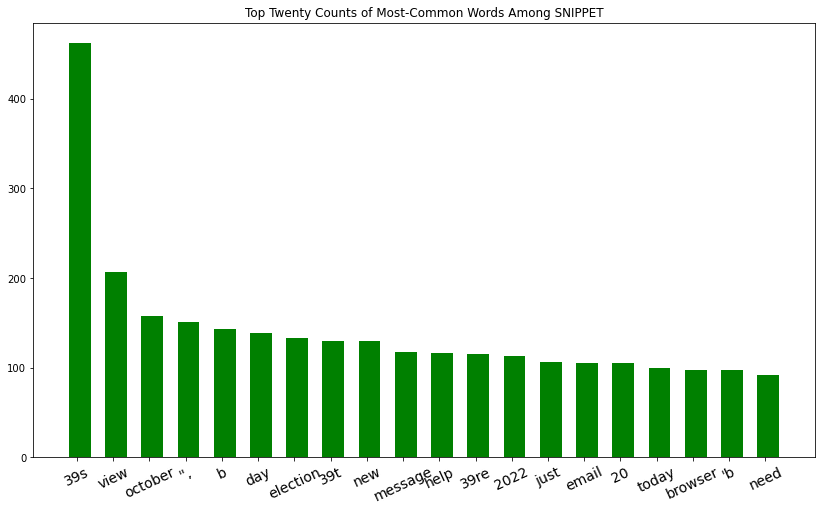

In [136]:
trainText = []
for it in df['snippet']:
    newT = textClean(it)
    trainText.append(newT)

tops = Counter(str(trainText).split()).most_common()[:20]
labs, vals = zip(*tops)
idx = np.arange(len(labs))
wid=0.6
fig, ax=plt.subplots(1,1,figsize=(14,8))
ax=plt.bar(idx, vals, wid, color='g')
ax=plt.xticks(idx - wid/8, labs, rotation=25, size=14)
plt.title('Top Twenty Counts of Most-Common Words Among SNIPPET')

Text(0.5, 1.0, 'Top Twenty Counts of Most-Common Words Among SENDER')

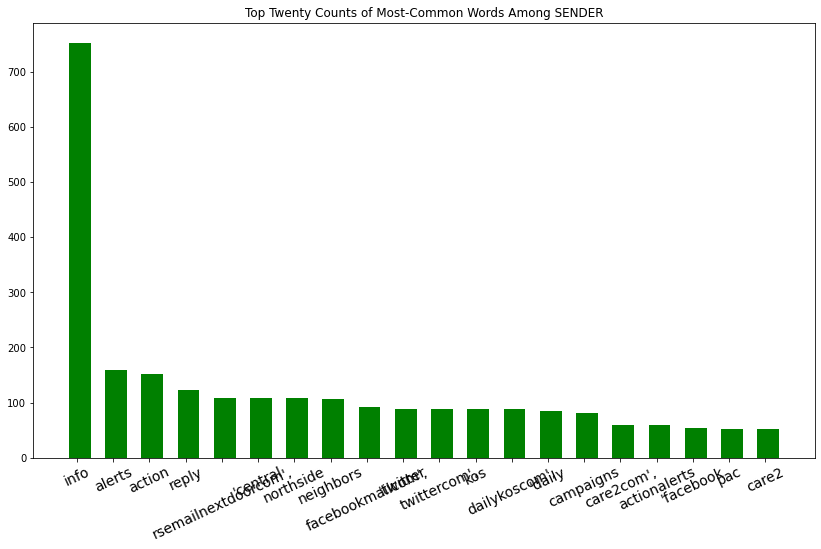

In [137]:
trainText = []
for it in df['sender']:
    newT = textClean(it)
    trainText.append(newT)

tops = Counter(str(trainText).split()).most_common()[:20]
labs, vals = zip(*tops)
idx = np.arange(len(labs))
wid=0.6
fig, ax=plt.subplots(1,1,figsize=(14,8))
ax=plt.bar(idx, vals, wid, color='g')
ax=plt.xticks(idx - wid/8, labs, rotation=25, size=14)
plt.title('Top Twenty Counts of Most-Common Words Among SENDER')

This listing is vastly different from the last iterations.

**How many of these are data science related?**

In [138]:
data_related = []
for item in df.subject:
    if 'data' in item.lower():
        data_related.append(item)

In [139]:
len(set(data_related))

18

In [140]:
data_related

['New Data: Thousands of Tenants are Being Denied RTC',
 'The 7 Best Practices to Move Your Machine Learning Projects into Production Faster Using Python | Bildea Ana in Towards Data Science',
 'CORRECTED DATA: Bill, They’re Counting On You Not to Show Up ',
 'A special note from MoveOn senior data scientist Allison Kelly',
 'How Data Scientists Level Up Their Coding Skills',
 'What’s the Hardest Part of Metric Design? | Cassie Kozyrkov in Towards Data Science',
 '7 Functions You Can Use to Create New Columns in a Pandas DataFrame | Soner Yıldırım in Towards Data Science',
 'How to Do an EDA for Time-Series | Fabiana Clemente in Towards Data Science',
 'Measuring User Engagement with Cohort Analysis | Mesut Can ALKAN in Towards Data Science',
 "Why I Decided to do a PhD in Machine Learning | Conor O'Sullivan in Towards Data Science",
 'How to Boost Pandas Speed And Process 10M-row Datasets in Milliseconds | BEXBoost in Towards Data Science',
 'A new application of structural entropy fo

I thought for sure I would have more data science related emails based on what I go through often.**

In [141]:
friend_related = []
for item in df.sender:
    if 'chris' in item.lower() or 'sheader' in item.lower():
        friend_related.append(item)

In [142]:
set(friend_related)

{'"Chris @ StubHub" <events@mail.stubhub.com>',
 '"Chris Kozlowski" <notification+54wbsrmn@facebookmail.com>',
 '"Mr. Michael Christopher" <mikechris078@gmail.com>',
 'Billing- Team <christopher6895368@gmail.com>',
 'Chris Deluzio <info@chrisforpa.com>',
 'Josh Shapiro <info@chrisforpa.com>',
 'PA-17 Race Alert <info@chrisforpa.com>',
 'Team Deluzio <info@chrisforpa.com>'}

I had to do a lot of filtering with the API directly to remove messages / chats from my friends. This highlights theyre no longer in there.

In [143]:
df1 = df[~df.labels.str.contains('CHAT')]
print(df1.shape)

(1870, 5)


**Confirmed no CHATS.**

In [144]:
df.labels.unique()

array(["['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']",
       "['CATEGORY_PROMOTIONS', 'UNREAD', 'IMPORTANT', 'INBOX']",
       "['CATEGORY_PROMOTIONS', 'UNREAD', 'SPAM']",
       "['CATEGORY_PROMOTIONS', 'UNREAD', 'TRASH']",
       "['CATEGORY_PROMOTIONS', 'UNREAD', 'IMPORTANT', 'TRASH']",
       "['CATEGORY_PROMOTIONS', 'INBOX']",
       "['CATEGORY_PROMOTIONS', 'IMPORTANT', 'TRASH']",
       "['UNREAD', 'CATEGORY_UPDATES', 'INBOX']",
       "['UNREAD', 'IMPORTANT', 'CATEGORY_UPDATES', 'INBOX']",
       "['UNREAD', 'TRASH', 'CATEGORY_UPDATES']",
       "['IMPORTANT', 'TRASH', 'CATEGORY_UPDATES']",
       "['IMPORTANT', 'CATEGORY_UPDATES', 'INBOX']",
       "['UNREAD', 'IMPORTANT', 'TRASH', 'CATEGORY_UPDATES']",
       "['UNREAD', 'Label_5184755793952638950', 'IMPORTANT', 'CATEGORY_UPDATES']",
       "['TRASH', 'CATEGORY_UPDATES']",
       "['UNREAD', 'CATEGORY_UPDATES', 'SPAM']",
       "['CATEGORY_UPDATES', 'INBOX']",
       "['UNREAD', 'IMPORTANT', 'CATEGORY_SOCIAL', 'INBOX']",
     

**These match up with what I pulled filter wise.**

In [145]:
df[(df.subject.str.contains('donat'))|(df.snippet.str.contains('donat'))]

,subject,sender,snippet,labels,subnsnip
index,,,,,
19,if you knew...,"""VoteVets.org"" <info@e.votevets.org>",By the time you read this... $3. If you knew a...,"['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']",if you knew...By the time you read this... $3....
118,Anything?,Ilhan Omar HQ <info@ilhanomar.com>,Can we convince you to chip in at this critica...,"['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']",Anything?Can we convince you to chip in at thi...
142,Please donate before our final deadlines ahead...,Mark Kelly <staff@dlcc.org>,We need an absolutely HUGE day today to stay o...,"['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']",Please donate before our final deadlines ahead...
192,2 weeks. 1 donation.,Dana Fritz <info@joshshapiro.org>,This election is just two weeks away ‌ ‌ ‌ ‌ ‌...,"['CATEGORY_PROMOTIONS', 'UNREAD', 'TRASH']",2 weeks. 1 donation.This election is just two ...
239,"A woman, her doctors, and her local politicians",The People United <hello@thepeopleunited.org>,His answer spoke volumes about who he thinks i...,"['CATEGORY_PROMOTIONS', 'UNREAD', 'TRASH']","A woman, her doctors, and her local politician..."
296,"$20,000 to boot Boebert?","""Boot Boebert! (Crazy Eight PAC)"" <info@thecra...",Watch our new ad to BOOT Lauren Boebert (and d...,"['CATEGORY_PROMOTIONS', 'UNREAD', 'TRASH']","$20,000 to boot Boebert?Watch our new ad to BO..."
315,the stakes couldn’t be higher in CA-03,"""Dr. Kermit Jones"" <info@cadem.org>",Hi - I&#39;m Kermit Jones and I&#39;m running ...,"['CATEGORY_PROMOTIONS', 'UNREAD', 'TRASH']",the stakes couldn’t be higher in CA-03Hi - I&#...
329,TIED,Tim Ryan <info@fightforprogress.org>,"Keep in mind, national Republicans have poured...","['CATEGORY_PROMOTIONS', 'UNREAD', 'TRASH']","TIEDKeep in mind, national Republicans have po..."
359,Headed towards COP27,WW0 News Team <enlist@worldwarzero.com>,As the world is just twelve days away from mee...,"['CATEGORY_PROMOTIONS', 'UNREAD', 'TRASH']",Headed towards COP27As the world is just twelv...


**These donation emails kinda fill up my inbox. They arent exactly spam but everyone needs donations.**

In [146]:
df[(df.subject.str.contains('sign'))|(df.snippet.str.contains('sign'))]

,subject,sender,snippet,labels,subnsnip
index,,,,,
35,Up to 60% OFF the good stuff (AKA: everything),Express <express@em.express.com>,Did someone say $5 Express Cash?! Don&#39;t fo...,"['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']",Up to 60% OFF the good stuff (AKA: everything)...
53,OUT NOW: H&M Studio A/W 2022,"""H&M Fashion News"" <newsletter@email.hm.com>","Futuristic fabrics, sculptural designs and bol...","['CATEGORY_PROMOTIONS', 'UNREAD', 'IMPORTANT',...",OUT NOW: H&M Studio A/W 2022Futuristic fabrics...
105,What do I do now?,2 Million Texans Campaign <lana@2milliontexans...,Early vote has started! Early vote has started...,"['CATEGORY_PROMOTIONS', 'UNREAD', 'SPAM']",What do I do now?Early vote has started! Early...
106,Ron Johnson wants to eliminate Social Security...,"""Fire Ron Johnson (Crazy Eight PAC)"" <info@the...","🚨SOUND. THE. ALARM! 🚨 If they take Congress, R...","['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']",Ron Johnson wants to eliminate Social Security...
139,Fighting through our frustrations,Julia Gledhill <reply@pogo.org>,There are roadblocks on the NDAA. But we&#39;r...,"['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']",Fighting through our frustrationsThere are roa...
459,"hamed farmand still needs you, Bill","""Change.org"" <change@e.change.org>",Change.org Thanks Bill for signing Urgent call...,"['CATEGORY_PROMOTIONS', 'UNREAD', 'TRASH']","hamed farmand still needs you, BillChange.org ..."
16,Morning Digest: Democrats defend Kansas House ...,Daily Kos Elections <electionsdigest@dailykos....,• KS-03: A Democratic group called Voter Prote...,"['UNREAD', 'IMPORTANT', 'CATEGORY_UPDATES', 'I...",Morning Digest: Democrats defend Kansas House ...
33,Penn State leaders should resign after approvi...,Daily Kos Recommended <campaigns@dailykos.com>,Daily Kos Recommended Subscribe to our podcast...,"['UNREAD', 'IMPORTANT', 'CATEGORY_UPDATES', 'I...",Penn State leaders should resign after approvi...
48,Voter Participation – Closing the Gap,League of Women Voters of California <lwvc@lwv...,"Dear Bill, Despite California recently passing...","['UNREAD', 'TRASH', 'CATEGORY_UPDATES']",Voter Participation – Closing the GapDear Bill...


**More political emails, looking for signatures maybe?**

### New Feature

**Rather than attempting to classify some of these, lets perform some unsupervised modeling on the subject + snippet + sender**

In [233]:
df['sss_join'] = df.subject + df.snippet# + df.sender

In [234]:
df.sss_join

index
0      Find community, path and purposePatagonia Acti...
1      5 reasons to give $5 just 5 days out from our ...
2      Enter for a chance to score Nita Strauss' favo...
3      Make some noise: Holiday deals are hereHi, put...
4      EXTRA 30% OFF CLEARANCE! Shop now for up to 80...
                             ...                        
495     Doug Mastriano: “I have direct control over t...
496    Falling short isn’t an option.Think we can hit...
497    ⚠️ We've got five Democratic women running in ...
498    Spread the word!‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ...
499    YOU CAN BE THE DIFFERENCE: Become an SDCC Amba...
Name: sss_join, Length: 1870, dtype: object

**Lets start with visualizations around my sub n snips**

In [235]:
text = []
for it in df['sss_join']:
    newT = textClean(it)
    text.append(newT)
    
joined_text = ' '.join(text)

In [236]:
from wordcloud import WordCloud

In [237]:
wordcloud = WordCloud(collocation_threshold = 2,
                      collocations= True,
                      background_color="white",
                      colormap="jet").generate(joined_text)

C:\Users\bills\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\bills\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\bills\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\bills\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

C:\Users\bills\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\bills\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\bills\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\bills\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

C:\Users\bills\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)


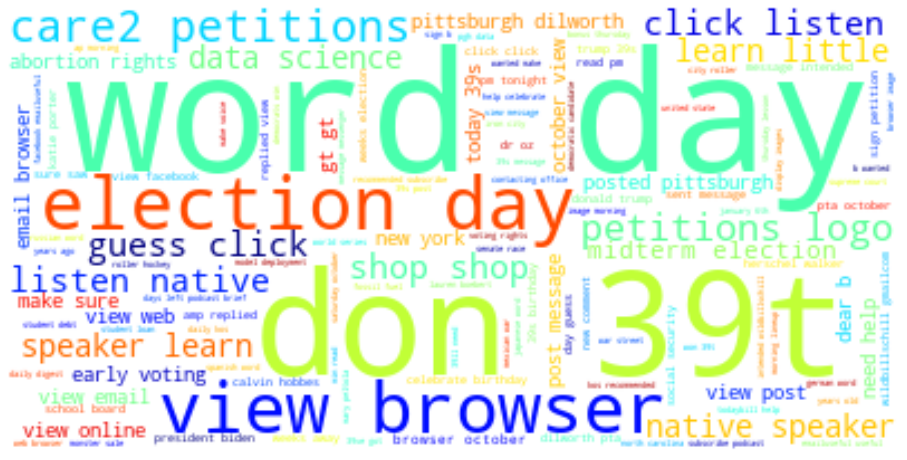

In [238]:
fig, ax=plt.subplots(1,1,figsize=(16,12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off");

Yes, this looks like an obvious word cloud from my inbox:
- word, listen, native are classifications relative to my interest in languages
- data science
- lots of variations in politics
- pittsburgh relevant things (hometown)

### Sentiment Analysis

Lets see if we can do a quick sentiment analysis on the emails that I pulled.
References:
- https://medium.com/@rukshanjayasekara/text-classification-with-fasttext-5cac26ce7bc6
- https://medium.com/@nikitasilaparasetty/twitter-sentiment-analysis-for-data-science-using-python-in-2022-6d5e43f6fa6e
- The "fasttext" package looked interesting but not as easy to obtain as texblob so we will go with textblob.

In [239]:
from textblob import TextBlob

In [240]:
def get_sentiment_df(text):
    ''' Gets sentiment for emails in text.
        Params = = = = = = = = = = = = = =
        text = non joined list of texts
        
        Returns = = = = = = = = = = = = = 
        sentiment data frame
    '''
    sentiment_objects = [TextBlob(t) for t in text]
    sentiment_values = [[t.sentiment.polarity, str(t)] for t in sentiment_objects]
    sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "email"])
    return sentiment_df

In [155]:
sentiment_df = get_sentiment_df(text)
print(sentiment_df.shape)

(1870, 2)


In [156]:
sentiment_df.head()

,polarity,email
0,0.266667,community path purposepatagonia action works m...
1,0.000000,5 reasons 5 just 5 days deadlinehelp tammy hit...
2,0.766667,enter chance score nita strauss' favorite gear...
3,0.562500,make noise holiday deals herehi pumpkin spice ...
4,0.159091,extra 30 clearance! shop 80 off!plus save 30 i...


In [157]:
sentiment_df.polarity.describe()

count    1870.000000
mean        0.105714
std         0.250481
min        -1.000000
25%         0.000000
50%         0.025000
75%         0.233902
max         1.000000
Name: polarity, dtype: float64

C:\Users\bills\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


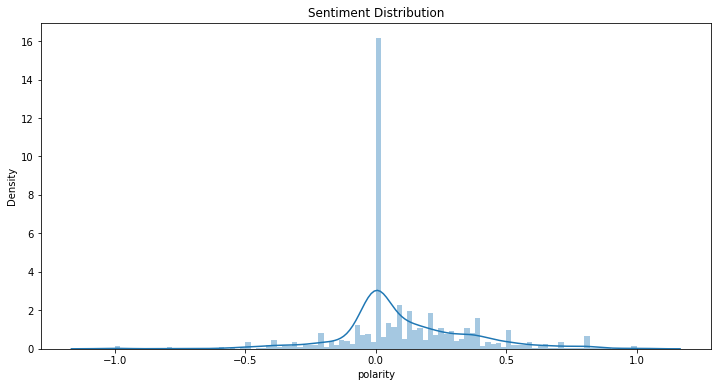

In [158]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
sns.distplot(sentiment_df.polarity, ax=ax, bins=100)
ax.set_title('Sentiment Distribution');

- We have some very negative and some very positive emails.
- Given that the mean is 0 it is relatively normal with a slight positive skew.

**What are the most negative emails?**

In [159]:
desc = sentiment_df.describe(percentiles=[0.1])

sentiment_df[sentiment_df.polarity <= desc.loc['10%'].values[0]]

,polarity,email
32,-0.375000,25 ends tonight ya sucker!
33,-0.125000,dylan dead day greenwolfgang 39s feautured gra...
36,-0.343750,s abhorrent! donkeys forced haul tons gold min...
52,-0.325000,signature needed prevent oil spill gulfyour ac...
57,-0.125000,pulled record s showsas best supporters hope 3...
...,...,...
1784,-0.312500,james carville sees truth james carville gets ...
1797,-0.212500,delayed payment dear friend mrmicheal noah wor...
1798,-0.166667,reply soon possiblegood day thank god survived...
1823,-0.200000,future lineb 39s secret maga republicans attac...


There are 188 emails in the bottom 10 %.

In [160]:
bottom_10 = sentiment_df[sentiment_df.polarity <= desc.loc['10%'].values[0]].email

wc_neg10 = WordCloud(collocation_threshold = 2,
                      collocations= True,
                      background_color="white",
                      colormap="jet").generate(' '.join(bottom_10))

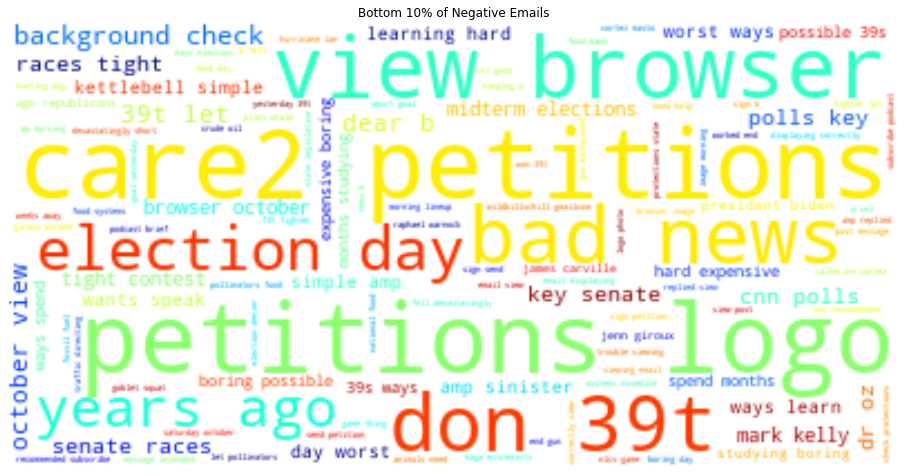

In [161]:
fig, ax=plt.subplots(1,1,figsize=(16,12))
ax.imshow(wc_neg10, interpolation='bilinear')
ax.set_title("Bottom 10% of Negative Emails")
ax.axis("off");

Looks like a lot of political things which isnt that surprising.

In [162]:
negative1s = sentiment_df[sentiment_df.polarity == -1].email

wc_neg1s = WordCloud(collocation_threshold = 2,
                      collocations= True,
                      background_color="white",
                      colormap="jet").generate(' '.join(negative1s))

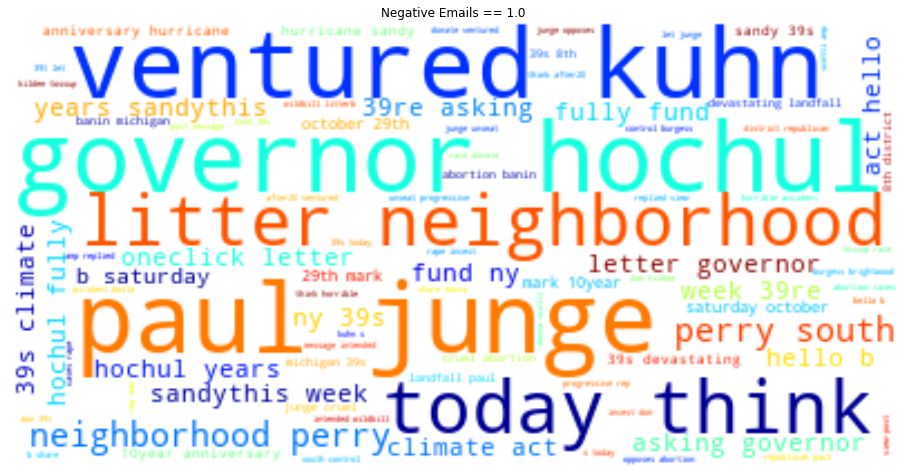

In [163]:
fig, ax=plt.subplots(1,1,figsize=(16,12))
ax.imshow(wc_neg1s, interpolation='bilinear')
ax.set_title("Negative Emails == 1.0")
ax.axis("off");

OOF. Talking a lot about some pittsburgh neighborhoods.

### Unsupervised Topic Modeling

Lets take a trip down unsupervised learning and see if we can garner topics for this list of emails. This way, if we do decide to do any classification later, we at least have some sort of automated set for labeling.

In [198]:
import os

import spacy 
from spacy import displacy

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel, LsiModel, HdpModel
from gensim.utils import simple_preprocess

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bills\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [70]:
nlp = spacy.load('en_core_web_sm')

In [164]:
join_text = ' '.join(text)
join_text[:100]

'community path purposepatagonia action works makes easy make difference 5 reasons 5 just 5 days dead'

In [166]:
text_list = [i for i in join_text.split(' ')]
text_list[:10]

['community',
 'path',
 'purposepatagonia',
 'action',
 'works',
 'makes',
 'easy',
 'make',
 'difference',
 '5']

We could do some analysis on tokenization in POS or Named Entities but were going to jump into topic modeling. Additonally, we already have most of the text cleaning completed.

In [262]:
## extend the stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'com', 'schill', 'hnatkovich',
                  ## oddball items
                   'calvin','hobbes','wildbillschill','watterson',
                  ## month relevancy
                   'october','september','august','november',
                  ## other
                   'day','join','help'
                  ])

In [263]:
stop_words[-10:]

['hobbes',
 'wildbillschill',
 'watterson',
 'october',
 'september',
 'august',
 'november',
 'day',
 'join',
 'help']

In [264]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


data = sentiment_df.email.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['community', 'path', 'action', 'work', 'make', 'easy', 'make', 'difference']]


In [265]:
data_words[:1]

[['community',
  'path',
  'action',
  'works',
  'makes',
  'easy',
  'make',
  'difference']]

In [266]:
# Create Dictionary
id2word = Dictionary(data_lemmatized) #data_words)
# Create Corpus
texts = data_lemmatized #data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [267]:
# print(corpus)[0][:10]

### LSI MODEL

### Latent Semantic Indexing

In [269]:
# help(LsiModel)

In [270]:
lsi_model = LsiModel(corpus=corpus, num_topics=10, id2word=id2word)
lsi_model.show_topics(num_topics=10)

[(0,
  '0.343*"view" + 0.325*"election" + 0.255*"need" + 0.244*"message" + 0.183*"email" + 0.179*"new" + 0.165*"vote" + 0.163*"browser" + 0.158*"today" + 0.143*"week"'),
 (1,
  '-0.558*"view" + 0.378*"election" + -0.286*"message" + -0.238*"browser" + -0.198*"send" + 0.196*"vote" + 0.149*"voter" + 0.142*"need" + 0.142*"week" + -0.127*"new"'),
 (2,
  '-0.628*"message" + -0.335*"send" + 0.317*"new" + -0.178*"need" + 0.175*"word" + 0.160*"today" + 0.158*"browser" + 0.139*"spanish" + 0.138*"learn" + 0.135*"email"'),
 (3,
  '0.531*"word" + 0.369*"spanish" + 0.271*"learn" + 0.232*"spanishpod" + 0.225*"message" + 0.191*"native_speaker" + 0.186*"german" + -0.185*"new" + 0.156*"click_listen" + -0.142*"view"'),
 (4,
  '0.714*"new" + -0.306*"view" + -0.247*"browser" + -0.177*"email" + -0.175*"vote" + -0.174*"election" + 0.168*"message" + 0.099*"make" + 0.089*"free" + 0.086*"need"'),
 (5,
  '0.435*"election" + 0.313*"word" + 0.278*"new" + -0.264*"email" + 0.231*"vote" + -0.205*"want" + -0.179*"need

- I see a potential language topic
- a potential data science topic
- something relative to shopping
- a lot of birthday messages
- event related messages
- political messages

### Heirarchical Dirichlet Process

In [428]:
hdp_model = HdpModel(corpus=corpus, id2word=id2word)
hdp_model.show_topics()#[:10]

[(0,
  '0.002*donation + 0.002*huge + 0.002*problems_viewe + 0.002*litterb + 0.001*message + 0.001*sundayboss + 0.001*need + 0.001*today + 0.001*confluence + 0.001*online + 0.001*donate + 0.001*significant + 0.001*smoking + 0.001*career + 0.001*kindread + 0.001*nowwhen + 0.001*fire + 0.001*absolutely + 0.001*audiobook + 0.001*worthy'),
 (1,
  '0.002*kangaroos + 0.001*need + 0.001*pumpkin + 0.001*helpthere + 0.001*reinforce + 0.001*rainforest + 0.001*sweetnature + 0.001*heather + 0.001*votersvoter + 0.001*audaciously + 0.001*extremism + 0.001*recommend + 0.001*ventured + 0.001*moneyb + 0.001*nail + 0.001*spendehello + 0.001*able + 0.001*soda + 0.001*reminder + 0.001*collapse'),
 (2,
  '0.002*crystal + 0.001*accountref + 0.001*platform + 0.001*reinstate + 0.001*patient + 0.001*alive + 0.001*large + 0.001*latino + 0.001*rent + 0.001*kitten + 0.001*entire + 0.001*germanpod + 0.001*generate + 0.001*wave + 0.001*critical + 0.001*usthe + 0.001*ground + 0.001*penn + 0.001*explanationhere + 0.0

- lots of politics
- donations 
- some language stuffs
- various things 
- mixing of many words
- it prescribed 20 topics in total

### Latent Dirichlet Allocation

In [278]:
lda_model = LdaModel(corpus=corpus, num_topics=4, id2word=id2word)
lda_model.show_topics()

[(0,
  '0.009*"election" + 0.006*"view" + 0.006*"action" + 0.005*"message" + 0.005*"new" + 0.005*"voter" + 0.005*"people" + 0.004*"spanish" + 0.004*"say" + 0.004*"make"'),
 (1,
  '0.011*"view" + 0.010*"email" + 0.009*"election" + 0.008*"need" + 0.007*"browser" + 0.006*"new" + 0.006*"week" + 0.005*"message" + 0.005*"today" + 0.005*"know"'),
 (2,
  '0.010*"need" + 0.008*"today" + 0.008*"vote" + 0.007*"new" + 0.007*"election" + 0.005*"time" + 0.005*"view" + 0.005*"right" + 0.004*"race" + 0.004*"dear"'),
 (3,
  '0.010*"word" + 0.006*"view" + 0.006*"race" + 0.005*"state" + 0.005*"good" + 0.005*"time" + 0.005*"want" + 0.005*"need" + 0.005*"right" + 0.004*"logo"')]

- I am overwhelmed with political emails...
- So much so that it is very difficult to get anything out of this other than that.

In [286]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

C:\Users\bills\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.043540 -0.017434       1        1  27.556666
1     -0.017172 -0.055517       2        1  26.621724
2     -0.025653  0.071532       3        1  23.587001
3      0.086365  0.001419       4        1  22.234609, topic_info=                Term        Freq       Total Category  logprob  loglift
1096            word   84.000000   84.000000  Default  30.0000  30.0000
179            email  115.000000  115.000000  Default  29.0000  29.0000
2400  native_speaker   25.000000   25.000000  Default  28.0000  28.0000
177             time   76.000000   76.000000  Default  27.0000  27.0000
72              vote   93.000000   93.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
205            voter   15.626438   83.671846   Topic4  -5.8443  -0.1744
161             week   15.675409  103.905175   Topic4  -5.8412  -0.3879
6               work   14.191827   73.258442   Topic4  -5.9406  -0.1378
420          browser   14.304890   80.307158   Topic4  -5.9327  -0.2217
189            today   13.720838  115.409328   Topic4  -5.9744  -0.6260

[337 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3984      4  0.929758  absurd
0         1  0.569414  action
0         2  0.149132  action
0         3  0.162690  action
0         4  0.108460  action
...     ...       ...     ...
1096      4  0.624330    word
6         1  0.232055    work
6         2  0.286656    work
6         3  0.286656    work
6         4  0.191104    work

[610 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

### NOTES

- Iteration 1:
    - 10 topics seems like too much, the graph shows overlap for some
    - There are still some odd ball items, for example Calvin and Hobbes?? Not sure where that is coming from but I plan to add it to the stop words.
- Iteration 2:
    - After another iteration, there appears to be specifics towards language in topic 4.
    - Better separation.
    - October shows up a lot relative to this months emails.
- Iteration 3:
    - Based on some further modeling I am going to remove the words "day",  "join", and "help".
    - Although there is separation with 4 topics, there is still significant word over lap.
    
    
- **The LDA model is probably is the best bet and its too bad we could not get GUidedLDA working. The HDP model is interesting because at first glance it appears to have better separation of topics but digging deeper there is a lot of cross topic information in each of its prescribed topics.**

### Classification

Ideally, we would have been able to use the unsupervised models to create a labeling scenario we could use for classification. There are a TON of political related emails. I would also liked to have used "GuidedLDA" but I could not get it to build appropriately, although it was something I played around with enough in the past to post a "fix" for installation.

What we can do here, since the data set is small enough, is to provide labels manually for many of these emails.

### Donation / Petition Model

There werent enough emails relative to data science (whoops) to make a cool model for that, so I am going to focus on being able to separate donation emails from other. This is something that has bothered me a lot as I dont mind signing petitions but when you do that, you are often put on a list to also recieve donation request emails and this can really clutter up your inbox.

In [306]:
rejoined = [' '.join(item) for item in texts]

In [307]:
## donate flag
donates = []
for item in texts:
    if 'donate' in item or 'donation' in item:
        donates.append(1)
    else:
        donates.append(0)
 
## signature flag
petitions = []
for item in texts:
    if 'petition' in item or 'sign' in item or 'action' in item:
        petitions.append(1)
    else:
        petitions.append(0)

In [353]:
X = pd.DataFrame(rejoined, columns=['lemtext'])
print(X.shape)
X['donations'] = donates
X['petitions'] = petitions

(1870, 1)


In [354]:
X.head(10)

,lemtext,donations,petitions
0,community path action work make easy make diff...,0,1
1,reason day hit monthly goal election race heat...,0,0
2,enter chance score favorite boss gt effect ped...,0,0
3,make noise holiday deal herehi pumpkin spice p...,0,0
4,extra clearance shop save instore online score...,0,0
5,state legislative raceswe vote molecular level...,0,0
6,fossil fuel lobbyist pack bag need follow day ...,0,0
7,vote need immediate input calendar alert elect...,0,0
8,partisan hack,0,0
9,remake american democracy ballot beyondon demo...,0,0


In [355]:
import sidetable

In [356]:
X.stb.freq(['donations','petitions'])

,donations,petitions,count,percent,cumulative_count,cumulative_percent
0,0,0,1669,89.251337,1669,89.251337
1,0,1,115,6.149733,1784,95.401070
2,1,0,83,4.438503,1867,99.839572
3,1,1,3,0.160428,1870,100.000000


- **This is interesting! There are only 3 emails that have donation and petition cross over.**

- In any case, this is a tricky model since it is imbalanced heavily.
- We will classify those three cross emails as a separate category and drop them for now.
- We will make:
    - "donation" emails = 1
    - "petition" emails = 2

In [357]:
y = X.donations + 2*X.petitions

In [358]:
y.value_counts()

0    1669
2     115
1      83
3       3
dtype: int64

### Feature Creation

We will do simple numerical feature creation between the TFIDF and COUNT VECTORIZERS. There is likely to be some redundancy but perhaps we can improve on that with PCA.

Edit - there was redundancy and in an effort to keep it simple, we are moving to just TFIDF as it should perform fine. The count vec is better for bag of words.

In [393]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, multilabel_confusion_matrix

In [453]:
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=100, max_df=0.8)
tv = tfidf.fit_transform(X.lemtext)

# cntv = CountVectorizer(ngram_range=(1,3), max_features=100, max_df=0.8)
# cv = cntv.fit_transform(X.lemtext)

In [454]:
feats = tv.todense() #np.concatenate((tv.todense(), cv.todense()), axis=1)
print(feats.shape)

(1870, 100)


#### PCA 

Just checking the variance and linearity between these features.

In [480]:
from sklearn.decomposition import PCA

In [484]:
pca = PCA(n_components=20)
pca_fit = pca.fit_transform(feats)

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


In [485]:
pca.explained_variance_ratio_.cumsum()

array([0.03185216, 0.05947735, 0.08481791, 0.10921275, 0.13231863,
       0.15523829, 0.17596386, 0.19569722, 0.21349412, 0.23052451,
       0.24692345, 0.26280161, 0.2778831 , 0.29263498, 0.30715569,
       0.32123009, 0.33513322, 0.34824177, 0.36132202, 0.3741541 ])

The features arent that correlated as after 20 components we only get to about 37% variance explained so given that we have 100 features, it probably doesnt make sense to bother with this here. Might be more useful for combined features like TFIDF + Count Vec.

### Splits and Training

We will split using a simple kfold and use a Random Forest model. This model tends to do fairly well with imbalanced data since its a bag of weak learners in this case. We could work hard to create grid search for this model, but given our data set size and applicability, I think setting a simple strong n estimator and not too deep depth should work fine.

In [455]:
kf = KFold(n_splits=8, shuffle=True)
# kf = RepeatedStratifiedKFold(n_splits=8, n_repeats=4)

# weights = {0:1.0, 1:(1669/84), 2:(1669/115)}
rf = RandomForestClassifier(n_estimators=500, max_depth=7, class_weight='balanced')

In [456]:
xf = pd.DataFrame(feats)
xf.columns = [f"feat{i+1}" for i in range(feats.shape[1])]

xf['target'] = y

In [457]:
## drop donation and petition ones
xf = xf[(xf.target!=3)]
print(xf.shape)

(1867, 101)


In [458]:
train, test = train_test_split(xf, test_size=0.3)
print(train.shape, test.shape)

print("Target Emails Splits")
pd.concat([train.target.value_counts(), train.target.value_counts(normalize=True)*100,
           test.target.value_counts(), test.target.value_counts(normalize=True)*100],axis=1)

(1306, 101) (561, 101)
Target Emails Splits


,target,target,target,target
0,1166,89.280245,503,89.661319
2,82,6.278714,33,5.882353
1,58,4.441041,25,4.456328


**The train and tests sets are relatively balanced.**

For the cross validation method, we will continue using sklearn and use the "f1_weighted" scoring metric. We would likely be better served with a pipeline implementation of the feature transformations moving up to this point.

In [459]:
scores = cross_validate(rf, train.drop('target',axis=1), 
                          train['target'], scoring=['f1_weighted'], cv=kf, return_estimator=True, return_train_score=True)

In [460]:
list(zip(scores['train_f1_weighted'].round(4), scores['test_f1_weighted'].round(4)))

[(0.9891, 0.9808),
 (0.9873, 0.981),
 (0.9883, 0.9796),
 (0.9882, 0.9937),
 (0.9892, 0.9886),
 (0.9883, 0.9512),
 (0.9874, 0.9645),
 (0.9864, 0.9879)]

In [461]:
best_score = np.argmax(scores['test_f1_weighted'])
best_model = scores['estimator'][best_score]
print(best_score)
print(best_model)

3
RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=500)


In [462]:
preds = best_model.predict(test.drop('target',axis=1))

In [463]:
print(classification_report(preds, test.target))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       508
           1       0.84      0.95      0.89        22
           2       0.94      1.00      0.97        31

    accuracy                           0.99       561
   macro avg       0.93      0.98      0.95       561
weighted avg       0.99      0.99      0.99       561



This model seems to have a very easy time predicting donation emails but not quite as good as prediction petition emails.

In [464]:
X['target'] = y

## merge the original emails with the target to identify the test items for manula inspection
x_no3 = X[X.target!=3]
x_test = x_no3.loc[test.index]

### Petition Tests Examination

In [465]:
for item in x_test[x_test.target==2].lemtext:
    print(item, '\n')

hang threadthere way sugar coat dire look good week circuit court appeal rule defer action childhood arrival daca 

spotlight election crunch time democratic action late neck margin error turn critical wisconsin voter 

child homeless action heartbroken yesterday learn child go school permanent housing sleep street tell kid fail school 

ham farmand need billchangeorg thank sign urgent action stop islamic republic violence child protest step petition hero signing bill 

big action win people power work dear want share real breakthrough victory government finally agree right health action fundamental hardfought 

writing workbook improve russian end soon free resource russian learner chance big russianpod good way improve russian simply action quota dream goal 

low drug price ballotdear pay high price world prescription drug drug corporation rake outrageous profit year finally take real action start 

tomorrow close milk dignity month look excellent photoreport week action website sure

It looks like many of the petition emails include things like:
- take action
- petition
- sign_petition
- sign

They may not be specific items for petitions though so we would need to go back through on more manual basis to better identify them.

### Donations Test Examination

In [466]:
for item in x_test[x_test.target==1].lemtext:
    print(item, '\n')

timeopen democracy time donate item online auction go live run get impressive 

deliver rural michiganhelp run ad show rural voter donate compete hold tossup seat proud support democrat 

donate final deadline ahead election daywe need absolutely huge today stay track hit goal write ask say convince split contribution campaign 

katie_porter opponent dodge donate ad katie_porter reelection antichoice trump extremist register ask katie_porter believe 

harvest go climate carnage urgent aid need world food program donate see climate carnage scale flood continue warm country 

blunt donation email important oneb battleground state attorney general important line defense extremist law effort erode human right overturn roe_wade 

quadruplematch active new democratic donor xmatching receive final endofmonth deadline donation help support democratic candidate 

predator killing rule go draw board remain blue insta color donate send friend predatorrule federal judge rule national park service 

**I wish I had more emails with both "petitions" and "donate" in them so that I could see better how things separate out. In the past when I have tried to create manual filters in gmail for these types of things, it rarely worked out so I am surprised with these results as I think they might be a little over confident. In the future, I would need much more email data and we could potentially use different modeling techniques such deep learning which is usually better suited to NLP multi classification.**

In [467]:
import shap

In [468]:
explainer = shap.TreeExplainer(best_model,
                                 train.drop('target',axis=1),
                                 feature_dependence="independent")

feature_dependence = "independent" has been renamed to feature_perturbation = "interventional"! See GitHub issue #882.
Passing 1306 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [469]:
shap_values = explainer.shap_values(test.drop('target',axis=1))

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
NPY_ARRAY_UPDATEIFCOPY, NPY_ARRAY_INOUT_ARRAY, and NPY_ARRAY_INOUT_FARRAY are deprecated, use NPY_WRITEBACKIFCOPY, NPY_ARRAY_INOUT_ARRAY2, or NPY_ARRAY_INOUT_FARRAY2 respectively instead, and call PyArray_ResolveWritebackIfCopy before the array is deallocated, i.e. before the last call to Py_DECREF.
100%|===================| 1679/1683 [04:21<00:00]        UPDATEIFCOPY detected in array_dealloc.  Required call to PyArray_ResolveWritebackIfCopy or PyArray_DiscardWritebackIfCopy is missing
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If 

- https://h1ros.github.io/posts/sentiment-analysis-by-shap-with-logistic-regression/

In [472]:
tfidf.get_feature_names()

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


['abortion',
 'action',
 'ad',
 'ask',
 'ballot',
 'big',
 'browser',
 'call',
 'campaign',
 'candidate',
 'chance',
 'check',
 'climate',
 'come',
 'comment',
 'community',
 'country',
 'critical',
 'day',
 'deal',
 'dear',
 'democracy',
 'democratic',
 'donate',
 'election',
 'email',
 'end',
 'event',
 'fall',
 'family',
 'fight',
 'final',
 'free',
 'friend',
 'fund',
 'german',
 'get',
 'go',
 'good',
 'hear',
 'important',
 'know',
 'learn',
 'leave',
 'let',
 'live',
 'logo',
 'look',
 'make',
 'message',
 'month',
 'need',
 'new',
 'news',
 'online',
 'people',
 'post',
 'power',
 'protect',
 'race',
 'reach',
 'read',
 'republican',
 'right',
 'run',
 'say',
 'send',
 'share',
 'shop',
 'sign',
 'spanish',
 'speak',
 'start',
 'state',
 'stop',
 'support',
 'take',
 'tell',
 'thank',
 'thing',
 'think',
 'time',
 'today',
 'tomorrow',
 'tonight',
 'trump',
 'tweet',
 'update',
 'view',
 'view browser',
 'vote',
 'voter',
 'want',
 'way',
 'week',
 'win',
 'woman',
 'word',
 'work',
 'year']

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


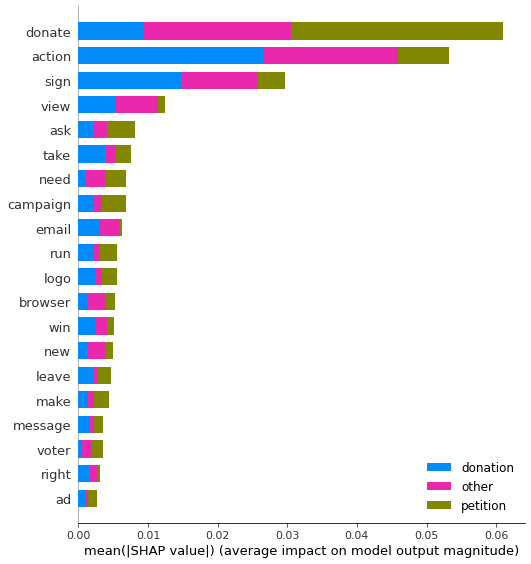

In [478]:
shap.summary_plot(shap_values,
                  test.drop('target',axis=1),
                  class_names=['other','petition','donation'],
                  feature_names=tfidf.get_feature_names())

It appears that donate, as suspected pushed for class 2 "donations" as well as action and sign... which leads me to believe that although this model appears good, that its always playing more towards the way I manually labeled them.

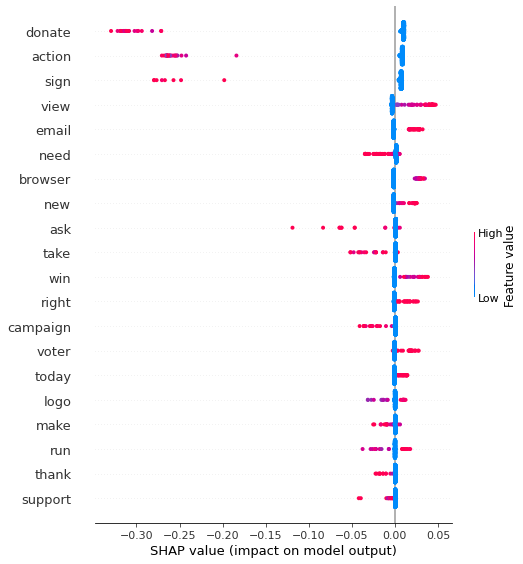

In [479]:
shap.summary_plot(shap_values[0],
                  test.drop('target',axis=1),
                  class_names=['other','petition','donation'],
                  feature_names=tfidf.get_feature_names(),
                  plot_type='dot')

In this instance of the feature examinations, once again, donation being class 2 is the higher of the feature values so more red where we would expect the petitions as class one to be purple-ish but they dont appear very obvious in the chart.

### FINAL THOUGHTS

As a whole, this project was interesting. Ive had a desire for a while to play around with my emails because of all the work I put into them manually but just never got around to it. In all my emails arent that intersting and there are a lot less data science related emails than I anticipated lol. 
The gmail API was the biggest pain point in getting to work but once it was working it worked well. The analysis side of it was relatively standard as far as NLP goes - word cloud and frequency counts. For the modeling, I chose something simple as I had already spent so much time on the GMAIL API issues but as it turns out, you dont necessarily need a lot to perfom classification and to do well on it even for imbalanced data sets. 
For the model speifically, the biggest issue probably comes down to the labeling I did. It was fairly simple and prone to many errors obviously. At the same time though, post text cleaning it was apparent that some of the words stood out very well. I think a big take away, one which I already assumed, was that even despite having only keywords, the difference between some of these political emails, whether they are asking for a donation or asking to sign a petition is that there very little difference betweem EXCEPT som key words.

### END

### old code

In [186]:
## VERSION 1.0

# def get_results(iters=10):
#     ''' Gets Results
#         Params:
#         = = = = = = = = = = = = = = = = = = = = 
#         iters = max number of iters to run while checking nextPageToken
        
#         Returns:
#         = = = = = = = = = = = = = = = = = = = = 
#         all_msgs = all messages list of data frames
#     '''
#     ## these are alredy confirmed to exist so skipping the check here
# #     SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']
# #     creds = Credentials.from_authorized_user_file('token.json', SCOPES)
# #     service = build('gmail', 'v1', credentials=creds)
    
#     pageToken = None
#     messages_left = True

#     all_msgs = []
#     # Get messages
#     while (messages_left) and (iters > 0):
#         results = service.users().messages().list(maxResults=500, userId="me", pageToken=pageToken).execute()
#         pageToken = results.get('nextPageToken')
#         # do something with the messages! Importing them to your database for example
        
#         clean_msgs = extract_data(results, service)
#         clean_df = pd.DataFrame(clean_msgs, columns=['subject',#'body',
#                                                      'sender','snippet',
#                                                      'labels'
#                                                     ])
#         all_msgs.append(clean_df)
        
#         iters -= 1
#         if not pageToken:
#             mesages_left = False
        
# #     results = service.users().messages().list(maxResults=n_results, userId='me').execute()
#     return all_msgs


# def extract_data(results, service):
#     ''' Function to pull in messages details.
#         Params:
#         = = = = = = = = = = = = = = = = = = = =
#         results = results from api call
        
#         Returns:
#         = = = = = = = = = = = = = = = = = = = =
#         List of message details per message
#     '''   
#     messages = results.get('messages')
#     all_msgs = []
#     start_time = time.time()
#     for msg in messages:
#         # Get the message from its id
#         txt = service.users().messages().get(userId='me', id=msg['id'],
#                                              format="full", metadataHeaders=None).execute()    
#         payload = txt['payload']
#         headers = payload['headers']
#         snippet = txt['snippet']
#         labels = txt['labelIds']
        
#         # Look for Subject and Sender Email in the headers
#         for d in headers:
#             if d['name'] == 'Subject':
#                 subject = d['value']
#             if d['name'] == 'From':
#                 sender = d['value']
            
# #             if not subject:
# #                 subject = None
# #             if not sender:
# #                 sender = None
        
#         ## there is just too much to sort through in the body
# #         try:
# #             parts = payload.get('parts')[0]
# #             data = parts['body']['data']
# #             data = data.replace("-","+").replace("_","/")
# #             decoded_data = base64.b64decode(data)
# #             soup = BeautifulSoup(decoded_data , "lxml")
# #             body = soup.body() 
# #         except:
# #             body = None

#         try:
#             all_msgs.append([subject, #body, 
#                              sender, snippet, 
#                              labels
#                             ])
#         except:
#             pass
#             ## skip ones that arent complete?
#     print(f"time to complete = {(time.time() - start_time)/60 :.3f} mins")
        
#     return all_msgs


In [297]:
## VERSION 2.0

# def get_results(iters=10, label_filter=None):
#     ''' Gets Results
#         Params:
#         = = = = = = = = = = = = = = = = = = = = 
#         iters = max number of iters to run while checking nextPageToken
        
#         Returns:
#         = = = = = = = = = = = = = = = = = = = = 
#         all_msgs = all messages list of data frames
#     '''
# #     SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']
# #     creds = Credentials.from_authorized_user_file('token.json', SCOPES)
# #     service = build('gmail', 'v1', credentials=creds)
    
#     pageToken = None
#     messages_left = True

#     all_msgs = []
#     # Get messages
#     while (messages_left) and (iters > 0):
#         results = service.users().messages().list(maxResults=500, includeSpamTrash=True,
#                                                   labelIds=label_filter,
#                                                   userId="me", pageToken=pageToken).execute()
#         pageToken = results.get('nextPageToken')
#         # do something with the messages! Importing them to your database for example
        
#         clean_msgs = extract_data(results, service)
#         clean_df = pd.DataFrame(clean_msgs, columns=['subject',#'body',
#                                                      'sender','snippet',
#                                                      'labels'
#                                                     ])
#         all_msgs.append(clean_df)
        
#         iters -= 1
#         if not pageToken:
#             mesages_left = False
        
# #     results = service.users().messages().list(maxResults=n_results, userId='me').execute()
#     return all_msgs


# def extract_data(results, service):
#     ''' Function to pull in messages details.
#         Params:
#         = = = = = = = = = = = = = = = = = = = =
#         results = results from api call
        
#         Returns:
#         = = = = = = = = = = = = = = = = = = = =
#         List of message details per message
#     '''   
#     messages = results.get('messages')
#     all_msgs = []
#     start_time = time.time()
#     for msg in messages:
#         # Get the message from its id
#         txt = service.users().messages().get(userId='me', id=msg['id'],
#                                              format="full", metadataHeaders=None).execute()   
        
#         ## set defaults to not confuse emails
#         subject, sender, snippet, labels = '', '', '', ['']
        
        
#         payload = txt['payload']
#         headers = payload['headers']
#         snippet = txt['snippet']
#         labels = txt['labelIds']
        
#         chat_count = 0
#         if 'CHAT' in str(txt['labelIds']):
#             chat_count += 1
#             pass
#         else:
#             # Look for Subject and Sender Email in the headers
#             for d in headers:
#                 if d['name'] == 'Subject':
#                     subject = d['value']
#                 if d['name'] == 'From':
#                     sender = d['value']
                    
#             try:
#                 all_msgs.append([subject, #body, 
#                                  sender, snippet, labels])
#             except:
#                 pass
#                 ## skip ones that arent complete?
    
#     print(f"Chat count = {chat_count}")
#     print(f"time to complete = {(time.time() - start_time)/60 :.3f} mins")
#     return all_msgs
